In [2]:
from functools import partial

import os
import io

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import cloudpickle
import json

# plotting
import matplotlib.pyplot as plt

import importlib as imp
import sklearn_utils
imp.reload(sklearn_utils)
from sklearn_utils import run_regressor_nested_cv

import ase
import ase.io
from ase.optimize import BFGS
from ase.constraints import FixAtoms, ExpCellFilter
from ase.io.trajectory import Trajectory


from ocpmodels.common.relaxation.ase_utils import OCPCalculator



/mnt/system/spack_nfs/spack_22Q4/spack_main/var/spack/environments/python-3p9-torch1p11-cuda-22Q4/.spack-env/view/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
checkpoint_path = "../models//gemnet_t_direct_h512_all.pt"
config_yml_path = "configs/s2ef/all/gemnet/gemnet-dT.yml"

data = pd.read_excel("data/dataset_pp.2022-12-09.xlsx", index_col=0)
data["structure"] = [ase.io.read(os.path.join(p, "POSCAR")) for p in data["path"]]

ads_idx = 100
ads_sample_name = data["System"].iloc[ads_idx]
ads_sample = data["structure"].iloc[ads_idx]
# Define the calculator
try:
    OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path)
except:
    pass

calc = OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path)

# Set up the calculator
ads_sample.calc = calc

os.makedirs("data/sample_ml_relax", exist_ok=True)
trajname = f"data/sample_ml_relax/{ads_sample_name}"

#ecf = ExpCellFilter(ads_sample)
opt = BFGS(ads_sample)
traj = Trajectory(f"{trajname}.traj", 'w', ads_sample)
opt.attach(traj)

nsteps = 100
opt.run(fmax=0.05, steps=nsteps)
traj.close()

traj = Trajectory(f"{trajname}.traj")

for i in range(0, nsteps+1):
    atoms = traj[i]
    with io.StringIO() as f, open(f"{trajname}.xyz", 'a') as xyz:
        ase.io.write(f, atoms, format='xyz')
        xyz.write(f.getvalue())


amp: false
cmd:
  checkpoint_dir: /mnt/projects/sne/felix_tests/playground-siby/checkpoints/2022-12-16-23-11-12
  commit: 7d1040b
  identifier: ''
  logs_dir: /mnt/projects/sne/felix_tests/playground-siby/logs/tensorboard/2022-12-16-23-11-12
  print_every: 100
  results_dir: /mnt/projects/sne/felix_tests/playground-siby/results/2022-12-16-23-11-12
  seed: null
  timestamp_id: 2022-12-16-23-11-12
dataset: null
gpus: 0
logger: tensorboard
model: gemnet_t
model_attributes:
  activation: silu
  cbf:
    name: spherical_harmonics
  cutoff: 6.0
  direct_forces: true
  emb_size_atom: 512
  emb_size_bil_trip: 64
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_rbf: 16
  emb_size_trip: 64
  envelope:
    exponent: 5
    name: polynomial
  extensive: true
  max_neighbors: 50
  num_after_skip: 2
  num_atom: 3
  num_before_skip: 1
  num_blocks: 3
  num_concat: 1
  num_radial: 128
  num_spherical: 7
  otf_graph: true
  output_init: HeOrthogonal
  rbf:
    name: gaussian
  regress_forces: true
  s

/mnt/projects/sne/felix_tests/ocp/ocpmodels/preprocessing/atoms_to_graphs.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /tmp/spack/spack-stage/spack-stage-py-torch-1.11.0-r54a54d44lhyvcaspd2ichthxn33ihyv/spack-src/torch/csrc/utils/tensor_new.cpp:210.)
  cell = torch.Tensor(atoms.get_cell()).view(1, 3, 3)
/mnt/system/spack_nfs/spack_22Q4/spack_main/var/spack/environments/python-3p9-torch1p11-cuda-22Q4/.spack-env/view/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/mnt/projects/sne/felix_tests/ocp/ocpmodels/models/gemnet/gemnet.py:373: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version

BFGS:    1 23:11:36       22.322475        0.2567
BFGS:    2 23:11:36       22.205025        0.2966
BFGS:    3 23:11:37       21.854771        0.5184
BFGS:    4 23:11:37       22.973986        1.9661
BFGS:    5 23:11:37       31.686724        3.2100
BFGS:    6 23:11:37       41.926876        4.0098
BFGS:    7 23:11:37       45.755047        4.5541
BFGS:    8 23:11:37       48.723202        4.6610
BFGS:    9 23:11:37       46.818424        4.6246
BFGS:   10 23:11:37       46.913113        4.6199
BFGS:   11 23:11:38       38.152443        3.8257
BFGS:   12 23:11:38       47.263012        2.9746
BFGS:   13 23:11:38       53.078342        2.3345
BFGS:   14 23:11:38       54.389008        1.3334
BFGS:   15 23:11:38       54.078045        1.2790
BFGS:   16 23:11:38       51.541737        1.7070
BFGS:   17 23:11:38       51.922527        0.9975
BFGS:   18 23:11:38       50.971870        0.7046
BFGS:   19 23:11:39       45.026306        0.7822
BFGS:   20 23:11:39       44.779217        0.8497


In [22]:
checkpoint_path = "../models//gemnet_t_direct_h512_all.pt"
config_yml_path = "configs/s2ef/all/gemnet/gemnet-dT.yml"

data = pd.read_excel("data/dataset_pp.2022-12-09.xlsx", index_col=0)
data["relaxed_structure"] = [ase.io.read(os.path.join(p, "CONTCAR")) for p in data["path"]]
data["initial_structure"] = [ase.io.read(os.path.join(p, "POSCAR")) for p in data["path"]]

try:
    OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path)
except:
    pass

calc = OCPCalculator(config_yml=config_yml_path, checkpoint=checkpoint_path)


oc20_energies_full = []
oc20_energies_surf = []
oc20_energies_mol = []
for ads_idx in range(len(data)):
    ads_sample_name = data["System"].iloc[ads_idx]
    ads_relaxed = data["relaxed_structure"].iloc[ads_idx]
    ads_initial = data["initial_structure"].iloc[ads_idx]
    
    ads_surf = ads_initial[np.array(ads_initial.get_chemical_symbols()) == "Mg"]
    ads_mol = ads_initial[np.array(ads_initial.get_chemical_symbols()) != "Mg"] # ...
    
    # Set up the calculator
    ads_relaxed.calc = calc
    energy_full = ads_relaxed.get_potential_energy()
    ads_surf.calc = calc
    energy_surf = ads_surf.get_potential_energy()
    if "CH4" in ads_sample_name:
        ads_mol.calc = calc
        energy_mol = ads_mol.get_potential_energy()
    else:
        energy_mol = None
    oc20_energies_full.append(energy_full)
    oc20_energies_surf.append(energy_surf)
    oc20_energies_mol.append(energy_mol)
data["Eo_full"] = oc20_energies_full
data["Eo_surf"] = oc20_energies_surf
data["Eo_mol"] = oc20_energies_mol
data["Eo_ads"] = data["Eo_full"] - (data["Eo_surf"] + data["Eo_mol"])

amp: false
cmd:
  checkpoint_dir: /mnt/projects/sne/felix_tests/playground-siby/checkpoints/2022-12-16-23-24-00
  commit: 7d1040b
  identifier: ''
  logs_dir: /mnt/projects/sne/felix_tests/playground-siby/logs/tensorboard/2022-12-16-23-24-00
  print_every: 100
  results_dir: /mnt/projects/sne/felix_tests/playground-siby/results/2022-12-16-23-24-00
  seed: null
  timestamp_id: 2022-12-16-23-24-00
dataset: null
gpus: 0
logger: tensorboard
model: gemnet_t
model_attributes:
  activation: silu
  cbf:
    name: spherical_harmonics
  cutoff: 6.0
  direct_forces: true
  emb_size_atom: 512
  emb_size_bil_trip: 64
  emb_size_cbf: 16
  emb_size_edge: 512
  emb_size_rbf: 16
  emb_size_trip: 64
  envelope:
    exponent: 5
    name: polynomial
  extensive: true
  max_neighbors: 50
  num_after_skip: 2
  num_atom: 3
  num_before_skip: 1
  num_blocks: 3
  num_concat: 1
  num_radial: 128
  num_spherical: 7
  otf_graph: true
  output_init: HeOrthogonal
  rbf:
    name: gaussian
  regress_forces: true
  s

/mnt/system/spack_nfs/spack_22Q4/spack_main/var/spack/environments/python-3p9-torch1p11-cuda-22Q4/.spack-env/view/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/mnt/projects/sne/felix_tests/ocp/ocpmodels/models/gemnet/gemnet.py:373: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  neighbors_new // 2,
/mnt/projects/sne/felix_tests/ocp/ocpmodels/models/gemnet/gemnet.py:467: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It

In [23]:
data[["E_ads", "Eo_ads"]]

,E_ads,Eo_ads
0,-0.505691,NaN
1,-0.482674,NaN
2,-0.457980,NaN
3,-0.507830,NaN
4,-0.199669,NaN
...,...,...
115,-0.326727,8.803629
116,-0.164033,5.836436
117,-0.150892,4.955469
118,-0.164847,5.682447


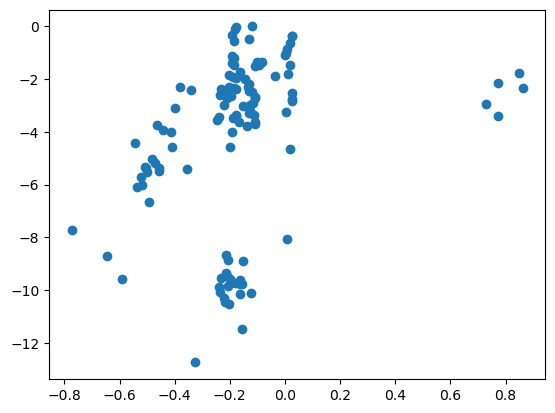